## Mounting Google Drive & loading training & test images

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'  'Getting started.pdf'   maskDetector   yolov3
 face_emotion	    images		   sd


In [7]:
!mkdir face_emotion
!pwd

/content


In [8]:
!cp /mydrive/face_emotion/data.zip face_emotion/

In [9]:
!unzip face_emotion/data.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/sad/Training_65275626.jpg  
 extracting: train/sad/Training_6529266.jpg  
 extracting: train/sad/Training_65329617.jpg  
 extracting: train/sad/Training_65338712.jpg  
 extracting: train/sad/Training_65338797.jpg  
 extracting: train/sad/Training_65387162.jpg  
 extracting: train/sad/Training_65404494.jpg  
 extracting: train/sad/Training_65426218.jpg  
 extracting: train/sad/Training_65430136.jpg  
 extracting: train/sad/Training_65437377.jpg  
 extracting: train/sad/Training_6545735.jpg  
 extracting: train/sad/Training_65463385.jpg  
 extracting: train/sad/Training_65473985.jpg  
 extracting: train/sad/Training_65502829.jpg  
 extracting: train/sad/Training_65505359.jpg  
 extracting: train/sad/Training_65508578.jpg  
 extracting: train/sad/Training_65516023.jpg  
 extracting: train/sad/Training_65524027.jpg  
 extracting: train/sad/Training_65526454.jpg  
 extracting: train/sad/Training_65531175.jpg  
 extracting

In [10]:
!ls

face_emotion  gdrive  model.png  sample_data  test  train


In [11]:
!pip install livelossplot

## Importing necessary libraries

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


In [13]:
print("Training set details: ")
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

Training set details: 
436 disgust images
4097 fear images
3171 surprise images
4965 neutral images
7214 happy images
4830 sad images
3995 angry images


In [14]:
print("Test set details:")
for expression in os.listdir("test/"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")

Test set details:
111 disgust images
1024 fear images
831 surprise images
1233 neutral images
1774 happy images
1247 sad images
958 angry images


## Setting dataset path

In [15]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
!ls

face_emotion  gdrive  model.png  sample_data  test  train


## Model Architecture


In [17]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training the model

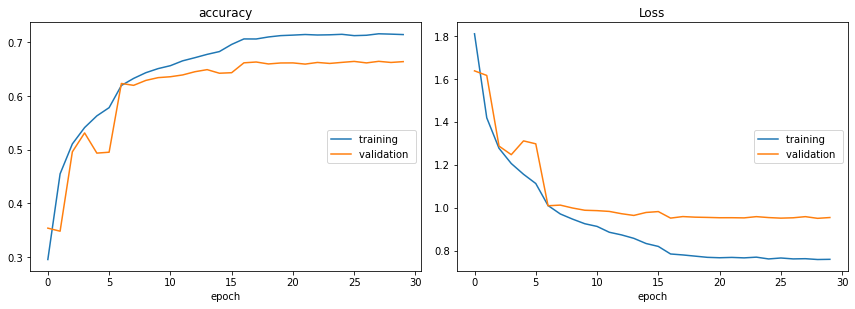

accuracy
	training         	 (min:    0.295, max:    0.716, cur:    0.715)
	validation       	 (min:    0.348, max:    0.665, cur:    0.664)
Loss
	training         	 (min:    0.759, max:    1.810, cur:    0.760)
	validation       	 (min:    0.950, max:    1.637, cur:    0.954)

Epoch 00030: saving model to model_weights.h5
448/448 [==============================] - 15s 32ms/step - loss: 0.7596 - accuracy: 0.7147 - val_loss: 0.9542 - val_accuracy: 0.6642 - lr: 1.0000e-05
CPU times: user 9min 38s, sys: 1min 23s, total: 11min 1s
Wall time: 7min 35s


In [18]:
%%time

epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [19]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [20]:
!cp model_weights.h5 /mydrive/face_emotion/